In [1]:
import razor
import razor.flow as rf
from razor import api
from razor.flow.spark import SparkBlock, SparkExecutor
import typing as t

In [2]:
import os
from datetime import datetime, timedelta
from pyspark.sql import SparkSession, functions
from pyspark.sql.dataframe import DataFrame
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [3]:
def project_space_path(path):
    ps = api.datasources('Project Space')
    return os.path.join(ps.abspath(), path)


In [4]:
@rf.block
class NonSparkPath:
    # Atomic input - csv filename relative to project space
    ip_path: str
    selected_cols: rf.Output[t.Any]
    # Atomic output of type spark DataFrame.
    op_path: rf.Output[str]
    def run(self):
        self.op_path.put(project_space_path(self.ip_path))
        

@rf.block
class NonSparkCols:
    cols_list: t.Any
    # Atomic input - csv filename relative to project space
    selected_cols: rf.Output[t.Any]
    # Atomic output of type spark DataFrame.
    def run(self):
        self.selected_cols.put(self.cols_list)
        

In [5]:
@rf.block
class ReadCsvProjectSpace(SparkBlock):
    filename:str
    data: rf.Output[DataFrame]
    def run(self):
        df = self.spark.read.csv(self.filename, header = True)
        print("Data Schema")
        df.printSchema()
        self.data.put(df)
        

@rf.block
class SelectData(SparkBlock):
    wanted_cols: t.Any
    inputData: DataFrame
    outputData: rf.Output[DataFrame]
    def run(self):
        df = self.inputData
        df_selected = df.select(self.wanted_cols)
        df_selected.show()
        self.outputData.put(df_selected)
        
        
        
        
        

In [6]:
nsp = NonSparkPath(ip_path='df_with_stats.csv')
nsc = NonSparkCols(cols_list = ['title','label'])
rcp = ReadCsvProjectSpace(filename = nsp.op_path, config={}, source="")
sd = SelectData(wanted_cols=nsc.selected_cols, inputData=rcp.data, config={}, source="")

# rcp.executor = rf.ProcessExecutor
# sd.executor = rf.ProcessExecutor

In [7]:
pipe = rf.Pipeline(targets = [sd])

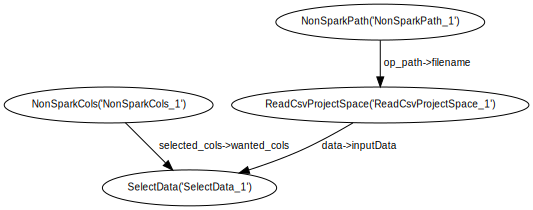

In [8]:
pipe

In [9]:
pipe.execute()

log path: /tmp/tmpk4q49koq/Pipeline_1


{}